# MLForge-Binary Tutorial: Adult Income Prediction

This comprehensive tutorial demonstrates all features of MLForge-Binary using the Adult Income dataset. We'll predict whether a person earns more than $50K/year based on demographic and employment features.

## Table of Contents
1. [Setup and Data Loading](#1-setup-and-data-loading)
2. [Exploratory Data Analysis](#2-exploratory-data-analysis)
3. [Basic Model Training](#3-basic-model-training)
4. [Advanced Features](#4-advanced-features)
5. [Model Comparison](#5-model-comparison)
6. [AutoML](#6-automl)
7. [Model Evaluation and Calibration](#7-model-evaluation-and-calibration)
8. [Explainable AI (XAI)](#8-explainable-ai-xai)
9. [Production Deployment](#9-production-deployment)

## 1. Setup and Data Loading

In [66]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import MLForge-Binary
from mlforge_binary import BinaryClassifier, AutoML, compare_models, quick_experiment

# Set visualization style
plt.style.use('default')
sns.set_palette('husl')

print("MLForge-Binary Tutorial")
print("=" * 50)

MLForge-Binary Tutorial


In [67]:
# Load the Adult Income dataset
# Column names for the Adult dataset
column_names = [
    'age', 'workclass', 'fnlwgt', 'education', 'education_num',
    'marital_status', 'occupation', 'relationship', 'race', 'sex',
    'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income'
]

# Load data from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
data = pd.read_csv(url, header=None, names=column_names, skipinitialspace=True)

# Also load test data
url_test = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
data_test = pd.read_csv(url_test, header=None, names=column_names, skipinitialspace=True, skiprows=1)

# Combine train and test for a larger dataset
data = pd.concat([data, data_test], ignore_index=True)

print(f"Dataset shape: {data.shape}")
print(f"\nFirst few rows:")
data.head()

Dataset shape: (48842, 15)

First few rows:


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [68]:
# Data preparation
# Clean the target variable
data['income'] = data['income'].str.replace('.', '', regex=False)
data['income'] = (data['income'] == '>50K').astype(int)

# Drop fnlwgt (sample weight) as it's not a predictive feature
data = data.drop('fnlwgt', axis=1)

# Handle missing values marked as '?'
data = data.replace('?', np.nan)

# Show data types and missing values
print("Data types and missing values:")
print("=" * 50)
for col in data.columns:
    missing_count = data[col].isnull().sum()
    missing_pct = missing_count / len(data) * 100
    print(f"{col:<20} {str(data[col].dtype):<10} Missing: {missing_count:>6} ({missing_pct:>5.1f}%)")

Data types and missing values:
age                  int64      Missing:      0 (  0.0%)
workclass            object     Missing:   2799 (  5.7%)
education            object     Missing:      0 (  0.0%)
education_num        int64      Missing:      0 (  0.0%)
marital_status       object     Missing:      0 (  0.0%)
occupation           object     Missing:   2809 (  5.8%)
relationship         object     Missing:      0 (  0.0%)
race                 object     Missing:      0 (  0.0%)
sex                  object     Missing:      0 (  0.0%)
capital_gain         int64      Missing:      0 (  0.0%)
capital_loss         int64      Missing:      0 (  0.0%)
hours_per_week       int64      Missing:      0 (  0.0%)
native_country       object     Missing:    857 (  1.8%)
income               int64      Missing:      0 (  0.0%)


In [69]:
# Separate features and target
X = data.drop('income', axis=1)
y = data['income']

# Identify categorical and continuous columns
categorical_cols = ['workclass', 'education', 'marital_status', 'occupation', 
                   'relationship', 'race', 'sex', 'native_country']
continuous_cols = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

print(f"Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"\nContinuous features ({len(continuous_cols)}): {continuous_cols}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nPositive class rate: {y.mean():.1%}")

Categorical features (8): ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']

Continuous features (5): ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']

Target distribution:
income
0    37155
1    11687
Name: count, dtype: int64

Positive class rate: 23.9%


## 2. Exploratory Data Analysis

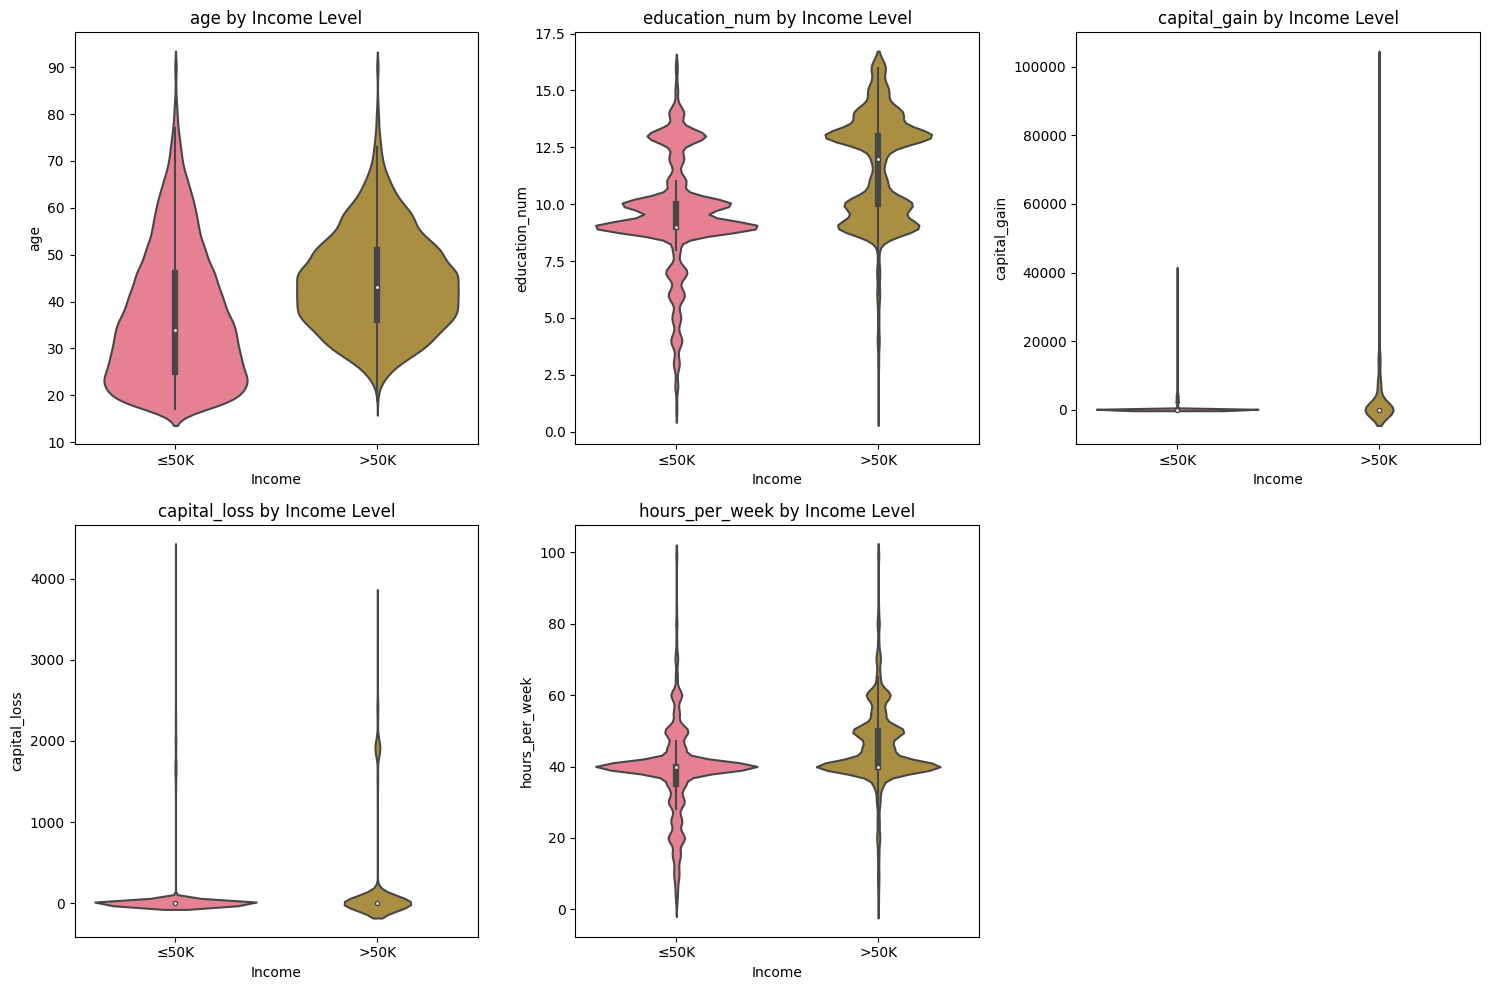

In [70]:
# Visualize continuous features by income level
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, col in enumerate(continuous_cols):
    ax = axes[i]
    
    # Create violin plot
    data_plot = pd.DataFrame({
        col: X[col],
        'income': y.map({0: '≤50K', 1: '>50K'})
    })
    
    sns.violinplot(data=data_plot, x='income', y=col, ax=ax)
    ax.set_title(f'{col} by Income Level')
    ax.set_xlabel('Income')

# Remove extra subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

In [71]:
# Analyze categorical features
print("Categorical Feature Analysis:")
print("=" * 60)

for col in categorical_cols[:3]:  # Show first 3 for brevity
    print(f"\n{col.upper()}:")
    
    # Calculate approval rate by category
    crosstab = pd.crosstab(X[col], y, normalize='index') * 100
    crosstab.columns = ['≤50K (%)', '>50K (%)']
    crosstab['Count'] = X[col].value_counts()
    
    print(crosstab.sort_values('>50K (%)', ascending=False).head(10))

Categorical Feature Analysis:

WORKCLASS:
                    ≤50K (%)   >50K (%)  Count
workclass                                     
Self-emp-inc       44.660767  55.339233   1695
Federal-gov        60.824022  39.175978   1432
Local-gov          70.440051  29.559949   3136
Self-emp-not-inc   72.112895  27.887105   3862
State-gov          73.245835  26.754165   1981
Private            78.213296  21.786704  33906
Without-pay        90.476190   9.523810     21
Never-worked      100.000000   0.000000     10

EDUCATION:
               ≤50K (%)   >50K (%)  Count
education                                
Prof-school   26.019185  73.980815    834
Doctorate     27.441077  72.558923    594
Masters       45.088446  54.911554   2657
Bachelors     58.716511  41.283489   8025
Assoc-acdm    74.203623  25.796377   1601
Assoc-voc     74.672489  25.327511   2061
Some-college  81.035117  18.964883  10878
HS-grad       84.142169  15.857831  15784
12th          92.694064   7.305936    657
7th-8th       

## 3. Basic Model Training

In [72]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nPositive class rate:")
print(f"  Train: {y_train.mean():.1%}")
print(f"  Test: {y_test.mean():.1%}")

Training set: (39073, 13)
Test set: (9769, 13)

Positive class rate:
  Train: 23.9%
  Test: 23.9%


In [73]:
# Example 1: Simple Logistic Regression
print("Training Simple Logistic Regression...")
print("=" * 50)

# Create and train model
clf_simple = BinaryClassifier(
    model='logistic',
    calibrate=False,  # No calibration for baseline
    verbose=True
)

# MLForge handles missing values and categorical encoding automatically!
clf_simple.fit(X_train, y_train)

# Evaluate
results_simple = clf_simple.evaluate(X_test, y_test)
print(f"\nTest Performance:")
print(f"  ROC AUC: {results_simple['metrics']['roc_auc']:.3f}")
print(f"  F1 Score: {results_simple['metrics']['f1_score']:.3f}")
print(f"  Accuracy: {results_simple['metrics']['accuracy']:.3f}")

Training Simple Logistic Regression...
[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (39073, 113)
[MLForge] Using logistic model...
[MLForge] Training model...
[MLForge] Optimizing classification threshold...
[MLForge] Optimal threshold: 0.600 (F1: 0.689)
[MLForge] Calculating training metrics...
[MLForge] Training completed in 11.89 seconds

Test Performance:
  ROC AUC: 0.905
  F1 Score: 0.690
  Accuracy: 0.835


In [74]:
# Example 2: Random Forest with automatic preprocessing
print("Training Random Forest...")
print("=" * 50)

clf_rf = BinaryClassifier(
    model='random_forest',
    handle_missing='iterative',     # Advanced missing value imputation
    handle_categorical='target',    # Target encoding for categorical variables
    calibrate=True,                # Probability calibration
    optimize_threshold=True,       # Find optimal classification threshold
    verbose=True
)

clf_rf.fit(X_train, y_train)

# Evaluate
results_rf = clf_rf.evaluate(X_test, y_test)
print(f"\nTest Performance:")
print(f"  ROC AUC: {results_rf['metrics']['roc_auc']:.3f}")
print(f"  F1 Score: {results_rf['metrics']['f1_score']:.3f}")
print(f"  Optimal Threshold: {clf_rf.optimal_threshold_:.3f}")

Training Random Forest...
[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (39073, 13)
[MLForge] Using random_forest model...
[MLForge] Training model...
[MLForge] Calibrating probabilities...
[MLForge] Optimizing classification threshold...
[MLForge] Optimal threshold: 0.350 (F1: 0.904)
[MLForge] Calculating training metrics...
[MLForge] Training completed in 3.00 seconds

Test Performance:
  ROC AUC: 0.907
  F1 Score: 0.690
  Optimal Threshold: 0.350


## 4. Advanced Features

In [75]:
# Example 3: Gradient Boosting with Feature Engineering
print("Training LightGBM with Feature Engineering...")
print("=" * 50)

clf_lgb = BinaryClassifier(
    model='lightgbm',
    feature_engineering=True,      # Add polynomial features
    feature_selection=True,        # Automatic feature selection
    handle_imbalanced='smote',     # Handle class imbalance
    calibrate=True,
    verbose=True
)

clf_lgb.fit(X_train, y_train)

results_lgb = clf_lgb.evaluate(X_test, y_test)
print(f"\nTest Performance:")
print(f"  ROC AUC: {results_lgb['metrics']['roc_auc']:.3f}")
print(f"  Average Precision: {results_lgb['metrics']['average_precision']:.3f}")

Training LightGBM with Feature Engineering...
[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (39073, 6441)
[MLForge] Using lightgbm model...
[MLForge] Training model...
[MLForge] Calibrating probabilities...
[MLForge] Optimizing classification threshold...
[MLForge] Optimal threshold: 0.350 (F1: 0.710)
[MLForge] Calculating training metrics...
[MLForge] Training completed in 575.17 seconds

Test Performance:
  ROC AUC: 0.917
  Average Precision: 0.802


In [76]:
# Example 4: Ensemble Model
print("Training Ensemble Model...")
print("=" * 50)

clf_ensemble = BinaryClassifier(
    model='ensemble',
    ensemble_models=['lightgbm', 'xgboost', 'random_forest'],
    ensemble_method='stacking',    # Use stacking instead of voting
    meta_learner='logistic',      # Logistic regression as meta-learner
    verbose=True
)

clf_ensemble.fit(X_train, y_train)

results_ensemble = clf_ensemble.evaluate(X_test, y_test)
print(f"\nTest Performance:")
print(f"  ROC AUC: {results_ensemble['metrics']['roc_auc']:.3f}")
print(f"  F1 Score: {results_ensemble['metrics']['f1_score']:.3f}")

Training Ensemble Model...
[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (39073, 113)
[MLForge] Creating ensemble model...
[MLForge] Training model...
[LightGBM] [Info] Number of positive: 7479, number of negative: 23779
[LightGBM] [Info] Number of positive: 7479, number of negative: 23780
[LightGBM] [Info] Number of positive: 7479, number of negative: 23779
[LightGBM] [Info] Number of positive: 7479, number of negative: 23779
[LightGBM] [Info] Number of positive: 7480, number of negative: 23779
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 517
[LightGBM] 

## 5. Model Comparison

In [77]:
# Compare multiple models systematically
print("Comparing Multiple Models...")
print("=" * 50)

# Sample data for faster comparison
X_comp = X.sample(5000, random_state=42)
y_comp = y.loc[X_comp.index]
X_train_comp, X_test_comp, y_train_comp, y_test_comp = train_test_split(
    X_comp, y_comp, test_size=0.2, random_state=42, stratify=y_comp
)

# Compare models with different preprocessing strategies
comparison_results = compare_models(
    X_train_comp, y_train_comp, X_test_comp, y_test_comp,
    models=['logistic', 'random_forest'],  # Reduced set for speed
    metrics=['roc_auc', 'f1'],
    cv=3,  # Reduced CV folds
    include_preprocessing_variants=True  # Test different preprocessing strategies
)

print("\nModel Comparison Results:")
print(comparison_results.to_string(index=False))

Comparing Multiple Models...
Evaluating logistic...
Evaluating random_forest...

Model Comparison Results:
        model                                                     config  training_time  roc_auc       f1
     logistic      {'model': 'logistic', 'handle_categorical': 'target'}       2.278998 0.882737 0.642336
     logistic                                      {'model': 'logistic'}       3.728197 0.881153 0.650558
     logistic                   {'model': 'logistic', 'calibrate': True}       3.259757 0.881153 0.650558
     logistic           {'model': 'logistic', 'feature_selection': True}       3.971762 0.881153 0.650558
random_forest {'model': 'random_forest', 'handle_categorical': 'target'}       0.714108 0.877762 0.655532
random_forest                                 {'model': 'random_forest'}       0.895429 0.874445 0.643863
random_forest              {'model': 'random_forest', 'calibrate': True}       0.775311 0.874445 0.643863
random_forest      {'model': 'random_forest',

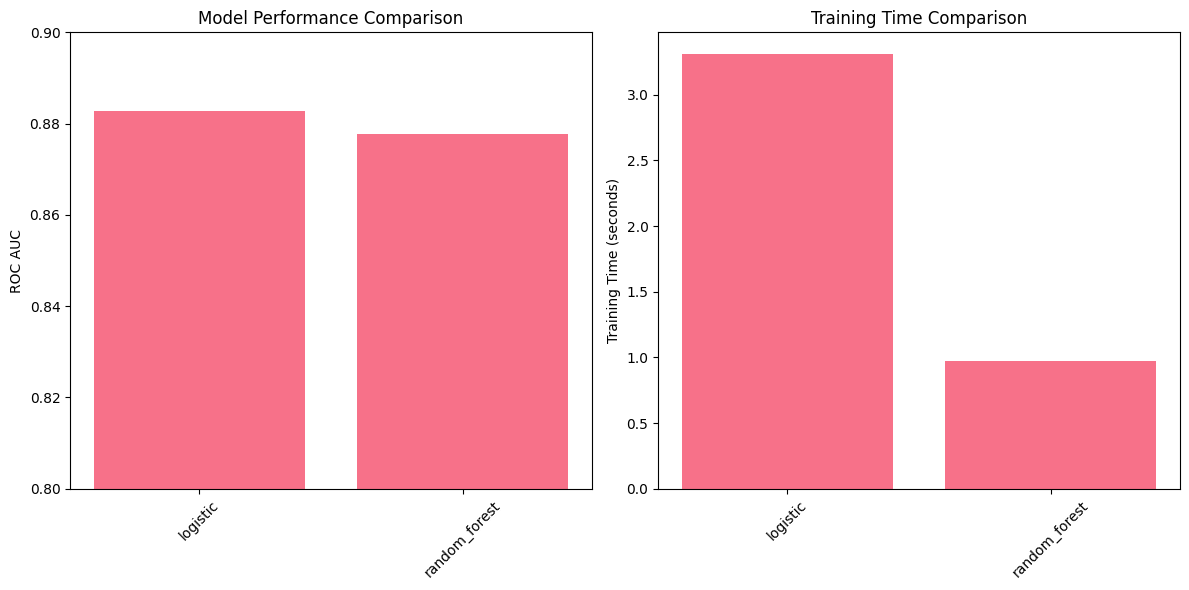

In [78]:
# Visualize model comparison
plt.figure(figsize=(12, 6))

# Plot ROC AUC comparison
plt.subplot(1, 2, 1)
model_names = comparison_results['model'].unique()
roc_scores = comparison_results.groupby('model')['roc_auc'].max()
plt.bar(range(len(model_names)), roc_scores.values)
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.ylabel('ROC AUC')
plt.title('Model Performance Comparison')
plt.ylim(0.8, 0.9)

# Plot training time comparison
plt.subplot(1, 2, 2)
train_times = comparison_results.groupby('model')['training_time'].mean()
plt.bar(range(len(model_names)), train_times.values)
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.ylabel('Training Time (seconds)')
plt.title('Training Time Comparison')

plt.tight_layout()
plt.show()

## 6. AutoML

In [80]:
# Quick AutoML experiment
print("Running Quick AutoML Experiment (30 seconds)...")
print("=" * 50)

# Reduce dataset size for quick demo
X_sample = X.sample(10000, random_state=42)
y_sample = y.loc[X_sample.index]

# Reduce time budget for demo
quick_results = quick_experiment(
    X_sample, y_sample,
    time_budget=30,  # 30 seconds for demo
    test_size=0.2,
    random_state=42
)

import sys
if sys.stdout.closed:
    sys.stdout = sys.__stdout__

print("\nQuick AutoML Results:")
print(quick_results['leaderboard'].head(5))
print(f"\nBest model test ROC AUC: {quick_results['test_metrics']['roc_auc']:.4f}")

Running Quick AutoML Experiment (30 seconds)...
Running quick experiment with 30 second budget...
[AutoML] Starting AutoML with 30 second budget...
[AutoML] Training on 6400 samples, validating on 1600 samples
[AutoML] Evaluating 18 model configurations...
[AutoML] ✓ random_forest: 0.8839 (±0.0065)
[AutoML] ✓ lightgbm: 0.8784 (±0.0047)
[AutoML] ✓ extra_trees: 0.8791 (±0.0053)
[AutoML] ✓ xgboost: 0.8962 (±0.0049)
[AutoML] ✓ lightgbm: 0.8784 (±0.0047)
[AutoML] Time budget exceeded, cancelling remaining jobs
[AutoML] ✓ xgboost: 0.9060 (±0.0061)
[AutoML] ✓ catboost: 0.9011 (±0.0044)
[AutoML] ✓ catboost: 0.9011 (±0.0044)
[AutoML] ✓ logistic_feateng: 0.8915 (±0.0047)
[AutoML] Top 10 Models:
[AutoML]  rank         model  score    std  training_time
    1      logistic 0.9049 0.0042        16.2099
    2       xgboost 0.8962 0.0049        27.6506
    3 random_forest 0.8839 0.0065         6.9549
    4   extra_trees 0.8791 0.0053        12.3459
    5      lightgbm 0.8784 0.0047         8.3196
[Au

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[AutoML] Final Test Set Evaluation:
[AutoML] Best Model Test ROC_AUC: 0.9074
[AutoML] Ensemble Test ROC_AUC: 0.9163
[AutoML] AutoML completed in 394.7 seconds

Quick AutoML Results:
   rank          model     score       std  training_time
0     1       logistic  0.904903  0.004189      16.209899
1     2        xgboost  0.896234  0.004878      27.650626
2     3  random_forest  0.883891  0.006485       6.954857
3     4    extra_trees  0.879135  0.005342      12.345876
4     5       lightgbm  0.878406  0.004663       8.319638

Best model test ROC AUC: 0.9016


In [81]:
# Full AutoML with custom configuration
print("Running Full AutoML (30 seconds)...")
print("=" * 50)

# Use the same smaller sample
automl = AutoML(
    time_budget=30,      # 30 seconds for demo
    ensemble_size=2,      # Top 2 models for ensemble
    metric='roc_auc',
    cv_folds=3,           # Reduce CV folds for speed
    verbose=True
)

# Use the sampled dataset to speed up the demo
automl.fit(X_sample, y_sample)

# Get best model
best_model = automl.get_best_model()
print(f"\nBest model configuration: {automl.leaderboard_.iloc[0]['model']}")

# Evaluate on test set
automl_predictions = best_model.predict_proba(X_test)[:, 1]
from sklearn.metrics import roc_auc_score
automl_auc = roc_auc_score(y_test, automl_predictions)
print(f"Best model test ROC AUC: {automl_auc:.4f}")

Running Full AutoML (30 seconds)...
[AutoML] Starting AutoML with 30 second budget...
[AutoML] Training on 8000 samples, validating on 2000 samples
[AutoML] Evaluating 18 model configurations...
[AutoML] ✓ random_forest: 0.8859 (±0.0082)
[AutoML] ✓ lightgbm: 0.8784 (±0.0116)
[AutoML] ✓ extra_trees: 0.8806 (±0.0100)
[AutoML] ✓ logistic: 0.9075 (±0.0082)
[AutoML] ✓ xgboost: 0.8986 (±0.0094)
[AutoML] ✓ lightgbm: 0.8784 (±0.0116)
[AutoML] ✓ xgboost: 0.9098 (±0.0065)
[AutoML] Time budget exceeded, cancelling remaining jobs
[AutoML] ✓ catboost: 0.9049 (±0.0092)
[AutoML] ✓ catboost: 0.9049 (±0.0092)
[AutoML] ✓ logistic_feateng: 0.8964 (±0.0079)
[AutoML] Top 10 Models:
[AutoML]  rank         model  score    std  training_time
    1      logistic 0.9075 0.0082        10.9991
    2       xgboost 0.8986 0.0094        17.5292
    3 random_forest 0.8859 0.0082         4.7043
    4   extra_trees 0.8806 0.0100         8.1424
    5      lightgbm 0.8784 0.0116         5.6797
    6      lightgbm 0.8784 

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/denizakdemir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

[AutoML] Final Test Set Evaluation:
[AutoML] Best Model Test ROC_AUC: 0.9015
[AutoML] Ensemble Test ROC_AUC: 0.9113
[AutoML] AutoML completed in 255.6 seconds

Best model configuration: logistic
Best model test ROC AUC: 0.9042


## 7. Model Evaluation and Calibration

In [82]:
# Generate comprehensive evaluation report
print("Generating Comprehensive Evaluation Report...")
print("=" * 50)

# Use the best performing model for detailed evaluation
best_clf = BinaryClassifier(
    model='lightgbm',
    calibrate=True,
    optimize_threshold=True
)

best_clf.fit(X_train, y_train)

# Generate HTML report with all visualizations
evaluation_results = best_clf.evaluate(
    X_test, y_test,
    generate_report=True,
    report_path='adult_income_evaluation_report.html'
)

print("\nDetailed Metrics:")
for metric, value in evaluation_results['metrics'].items():
    if isinstance(value, (int, float)) and not np.isnan(value):
        print(f"  {metric:<30}: {value:.4f}")

Generating Comprehensive Evaluation Report...
[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (39073, 113)
[MLForge] Using lightgbm model...
[MLForge] Training model...
[MLForge] Calibrating probabilities...
[MLForge] Optimizing classification threshold...
[MLForge] Optimal threshold: 0.350 (F1: 0.705)
[MLForge] Calculating training metrics...
[MLForge] Training completed in 1.36 seconds
Report saved to: adult_income_evaluation_report.html

Detailed Metrics:
  accuracy                      : 0.8385
  precision                     : 0.6330
  recall                        : 0.7737
  f1_score                      : 0.6963
  specificity                   : 0.8588
  negative_predictive_value     : 0.9235
  false_positive_rate           : 0.1412
  false_negative_rate           : 0.2263
  roc_auc                       : 0.9150
  average_precision             : 0.8004
  brier_score                   : 0.0950
  log_loss           

[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (39073, 113)
[MLForge] Using lightgbm model...
[MLForge] Training model...
[MLForge] Optimizing classification threshold...
[MLForge] Optimal threshold: 0.550 (F1: 0.703)
[MLForge] Calculating training metrics...
[MLForge] Training completed in 1.00 seconds
[MLForge] Starting model training...
[MLForge] Fitting preprocessing pipeline...
[MLForge] Processed data shape: (39073, 113)
[MLForge] Using lightgbm model...
[MLForge] Training model...
[MLForge] Calibrating probabilities...
[MLForge] Optimizing classification threshold...
[MLForge] Optimal threshold: 0.350 (F1: 0.705)
[MLForge] Calculating training metrics...
[MLForge] Training completed in 1.32 seconds


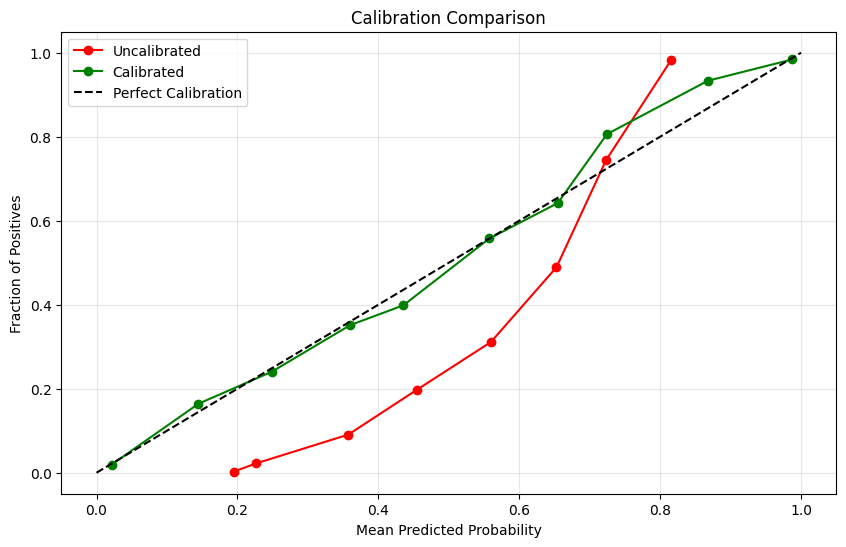

Notice how calibration improves the reliability of probability estimates!


In [83]:
# Analyze calibration
from sklearn.calibration import calibration_curve

# Get predictions from calibrated and uncalibrated models
clf_uncalibrated = BinaryClassifier(model='lightgbm', calibrate=False)
clf_calibrated = BinaryClassifier(model='lightgbm', calibrate=True)

clf_uncalibrated.fit(X_train, y_train)
clf_calibrated.fit(X_train, y_train)

y_prob_uncalibrated = clf_uncalibrated.predict_proba(X_test)[:, 1]
y_prob_calibrated = clf_calibrated.predict_proba(X_test)[:, 1]

# Plot calibration curves
plt.figure(figsize=(10, 6))

# Uncalibrated
fraction_pos_uncal, mean_pred_uncal = calibration_curve(
    y_test, y_prob_uncalibrated, n_bins=10
)
plt.plot(mean_pred_uncal, fraction_pos_uncal, 'o-', label='Uncalibrated', color='red')

# Calibrated
fraction_pos_cal, mean_pred_cal = calibration_curve(
    y_test, y_prob_calibrated, n_bins=10
)
plt.plot(mean_pred_cal, fraction_pos_cal, 'o-', label='Calibrated', color='green')

# Perfect calibration line
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Notice how calibration improves the reliability of probability estimates!")